## **CUSTOMER SENTIMENT CLASSIFICATION**

21064051 NguyenHungAnh

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Librairies**

Library Imports
The following libraries are used for data processing, visualization, machine learning, and deep learning:

Data Processing & Visualization: pandas, seaborn, matplotlib, wordcloud, nltk

Machine Learning: scikit-learn (Logistic Regression, CountVectorizer, TfidfVectorizer, Pipelines)

Deep Learning: PyTorch, Hugging Face Transformers (AutoTokenizer, AutoModelForSequenceClassification)

Utilities: joblib, numpy

In [ ]:
import re
import string
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder

import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

**Import DataSet**

3.Data Loading and Preprocessing
3.1 Load Dataset
The dataset is loaded from a CSV file containing customer feedback for sentiment analysis.

3.2 Data Splitting
The dataset consists of a single column with multiple values separated by commas. We split it into separate columns:

- Text: The customer feedback text

- Sentiment: The sentiment label (e.g., positive, negative, neutral)

- Source: The platform or source of the feedback

- Date/Time: The timestamp of the feedback

- User ID: The unique identifier of the customer

- Location: The geographical location of the customer

- Confidence Score: A numerical confidence score of the sentiment classification

3.3 Drop Redundant Column
After splitting, the original concatenated column is no longer needed and is removed.

3.4 Display Sample Data
To verify the preprocessing steps, the first few rows of the dataset are displayed.

In [23]:
customer_feedback = pd.read_csv("/content/drive/MyDrive/DEEP_LEARNING/dataset/sentiment-analysis.csv")

customer_feedback[['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']] = customer_feedback['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand = True)

customer_feedback = customer_feedback.drop('Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score', axis=1)
customer_feedback.head()

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88


**Data Cleaning**

4. Text Preprocessing

4.1 Clean Text:
- Convert to lowercase
- Remove non-alphabetic characters
- Remove extra spaces

4.2 Clean Sentiment Labels & Remove NaN:

In [ ]:
def clean_text(text: pd.Series) -> pd.Series:
    text = text.str.lower()

    text = text.str.replace(r'[^a-z\s]', '', regex=True)

    text = text.str.replace(r'\s+', ' ', regex=True).str.strip()

    return text
customer_feedback['Cleaned_Text'] = clean_text(customer_feedback['Text'])
customer_feedback['Sentiment'] = customer_feedback['Sentiment'].str.strip()

customer_feedback = customer_feedback.dropna()
customer_feedback

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score,Cleaned_Text
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85,i love this product
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65,the service was terrible
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92,this movie is amazing
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78,im so disappointed with their customer support
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88,just had the best meal of my life
...,...,...,...,...,...,...,...,...
91,"""Just had the most amazing vacation! I can't w...",Positive,TripAdvisor,2023-07-02 18:01:23,travelenthusiast1,Sydney,0.93,just had the most amazing vacation i cant wait...
92,"""The food at this restaurant was awful. Never ...",Negative,Zomato,2023-07-02 20:45:37,foodlover123,Mumbai,0.55,the food at this restaurant was awful never go...
93,"""I can't stop listening to this song. It's my ...",Positive,Spotify,2023-07-03 09:17:52,musiclover789,Berlin,0.91,i cant stop listening to this song its my new ...
94,"""Their website is so confusing and poorly desi...",Negative,Website Review,2023-07-03 11:59:18,user789,Toronto,0.68,their website is so confusing and poorly designed


**Data Preprocessing**

5. Sentiment Distribution Visualization:

5.1 Count Sentiment Labels:

- Calculate the frequency of each sentiment category

5.2 Plot Sentiment Distribution:

- Create a bar chart to visualize sentiment counts

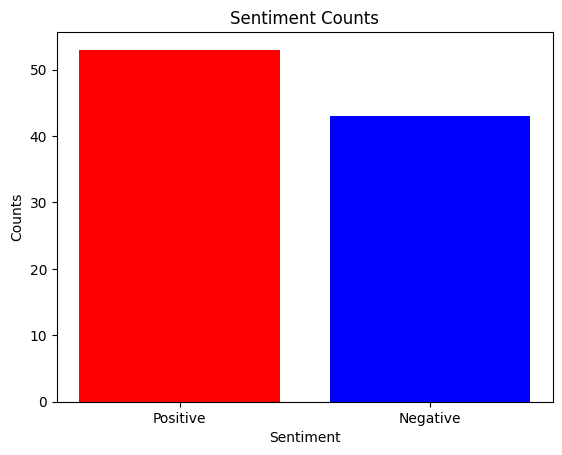

In [25]:
sentiment_counts = customer_feedback['Sentiment'].value_counts()

plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'blue'])

plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

plt.show()

**Model**

In [26]:
model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression())
])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(customer_feedback["Cleaned_Text"], customer_feedback["Sentiment"], test_size=0.2, random_state=42)

**Training model**

In [ ]:
model.fit(X_train, y_train)

joblib.dump(model, "sentiment_model.pkl")

y_pred = model.predict(X_test)
accuracy= accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

loaded_model = joblib.load("sentiment_model.pkl")


Accuracy: 0.9500
              precision    recall  f1-score   support

    Negative       0.83      1.00      0.91         5
    Positive       1.00      0.93      0.97        15

    accuracy                           0.95        20
   macro avg       0.92      0.97      0.94        20
weighted avg       0.96      0.95      0.95        20



Độ chính xác đạt 95%